This is my first Kaggle Notebook that I'll be uploading , the primary goal hereis to analyse the data and try to create a model to predict the prices and explore various data preprocessing and regression models .

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.special import boxcox1p
import plotly.express as px
# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.metrics import r2_score
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score,GridSearchCV,RepeatedStratifiedKFold,StratifiedKFold,KFold
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from fasteda import fast_eda
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
#Import the dataset
dataset = pd.read_csv("C:/Users/Lenovo/New folder/Sport_car_price.csv")

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


In [7]:
## Renaming the columns to make refering them more easier
dataset = dataset.rename(columns = {'Car Make': 'car_make',
    'Car Model': 'car_model',
    'Year': 'year',
    'Engine Size (L)': 'engine_size_L',
    'Horsepower': 'horsepower',
    'Torque (lb-ft)': 'torque',
    '0-60 MPH Time (seconds)': 'acceleration_seconds',
    'Price (in USD)': 'price_usd'
})

In [8]:
# Almost the entire dataset is given in the format of object data type to make a proper analysis 
# To do this I used List Comprehension with regular expressions to convert the data types to int or float depending on the feature
import re
pattern = r'^-?\d+(?:\.\d+)?$'
dataset['price_usd'] = [int(X.replace(",","")) for X in dataset['price_usd']]
dataset['engine_size_L'] = [float(X) if re.search(pattern,str(X)) else None for X in dataset['engine_size_L']]
dataset['horsepower'] = [int(X) if re.search(r'^[0-9]+$',str(X)) else None for X in dataset['horsepower']]
dataset['torque'] = [int(X) if re.search(r'^[0-9]+$',str(X)) else None for X in dataset['torque']]
dataset['acceleration_seconds'] = [float(X) if re.search(pattern,str(X)) else None for X in dataset['acceleration_seconds']]

In [10]:
dataset['price_usd'].describe()

count    1.007000e+03
mean     3.820359e+05
std      7.383227e+05
min      2.500000e+04
25%      7.180000e+04
50%      1.400000e+05
75%      2.500000e+05
max      5.200000e+06
Name: price_usd, dtype: float64

In [11]:
# Group by Car Model and count the number of cars
car_counts = dataset.groupby('car_make').size().reset_index(name='counts')

# Filter models with at least 10 cars
#car_counts = car_counts[car_counts['counts'] >= 10]

# Create the interactive bar chart
fig = px.bar(car_counts, x='car_make', y='counts', title='Number of cars produced by Carmake', 
             labels={'carmodel': 'Carmake', 'counts': 'Number of cars'})

# Show the plot
fig.show()

The "fast_eda" module in Python is a data analysis library that provides a quick and efficient way to perform exploratory data analysis (EDA) on large datasets. The fast_eda library is designed to simplify the EDA process by providing a set of functions and tools that allow users to quickly generate descriptive statistics, visualize data, and identify potential issues in the data.

DataFrame Head:


,car_make,car_model,year,engine_size_L,horsepower,torque,acceleration_seconds,price_usd
0,Porsche,911,2022,3.0,379.0,331.0,4.0,101200
1,Lamborghini,Huracan,2021,5.2,630.0,443.0,2.8,274390
2,Ferrari,488 GTB,2022,3.9,661.0,561.0,3.0,333750


DataFrame Tail:


,car_make,car_model,year,engine_size_L,horsepower,torque,acceleration_seconds,price_usd
1004,McLaren,Senna,2021,4.0,789.0,590.0,2.70,1000000
1005,Pagani,Huayra,2021,6.0,764.0,738.0,3.00,2600000
1006,Rimac,Nevera,2021,NaN,1888.0,1696.0,1.85,2400000


----------------------------------------------------------------------------------------------------
Missing values:


,0
engine_size_L,59
horsepower,9
torque,8
acceleration_seconds,1


----------------------------------------------------------------------------------------------------
MSNO Matrix:



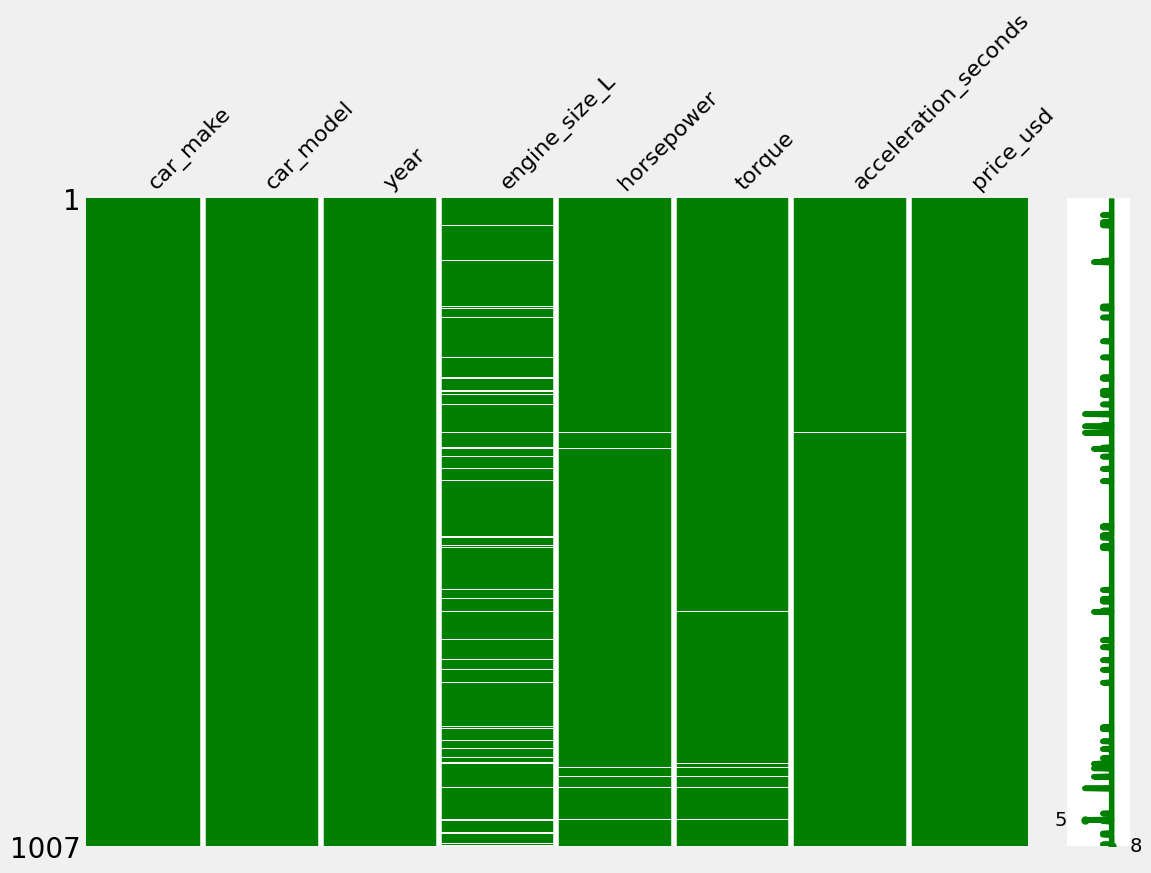

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(1007, 8)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   car_make              1007 non-null   object 
 1   car_model             1007 non-null   object 
 2   year                  1007 non-null   int64  
 3   engine_size_L         948 non-null    float64
 4   horsepower            998 non-null    float64
 5   torque                999 non-null    float64
 6   acceleration_seconds  1006 non-null   float64
 7   price_usd             1007 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 63.1+ KB
----------------------------------------------------------------------

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
year,1007,2021.202,2021,2.02,1965,2021,2021,2022,2023,-21.385491,565.440542
engine_size_L,948,4.396,4,1.399,0,3.5,4,5.2,8.4,0.541193,-0.242941
horsepower,998,627.325,591,299.974,181,454,591,671,2000,2.068799,6.057272
torque,999,542.185,509,242.509,0,406,509,604,1732,1.606085,4.291037
acceleration_seconds,1006,3.515,3.5,0.776,1.8,2.9,3.5,4,6.5,0.576632,0.047381
price_usd,1007,382035.941,140000,738322.716,25000,71800,140000,250000,5200000,3.798528,14.470888


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\fasteda\__init__.py:124: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



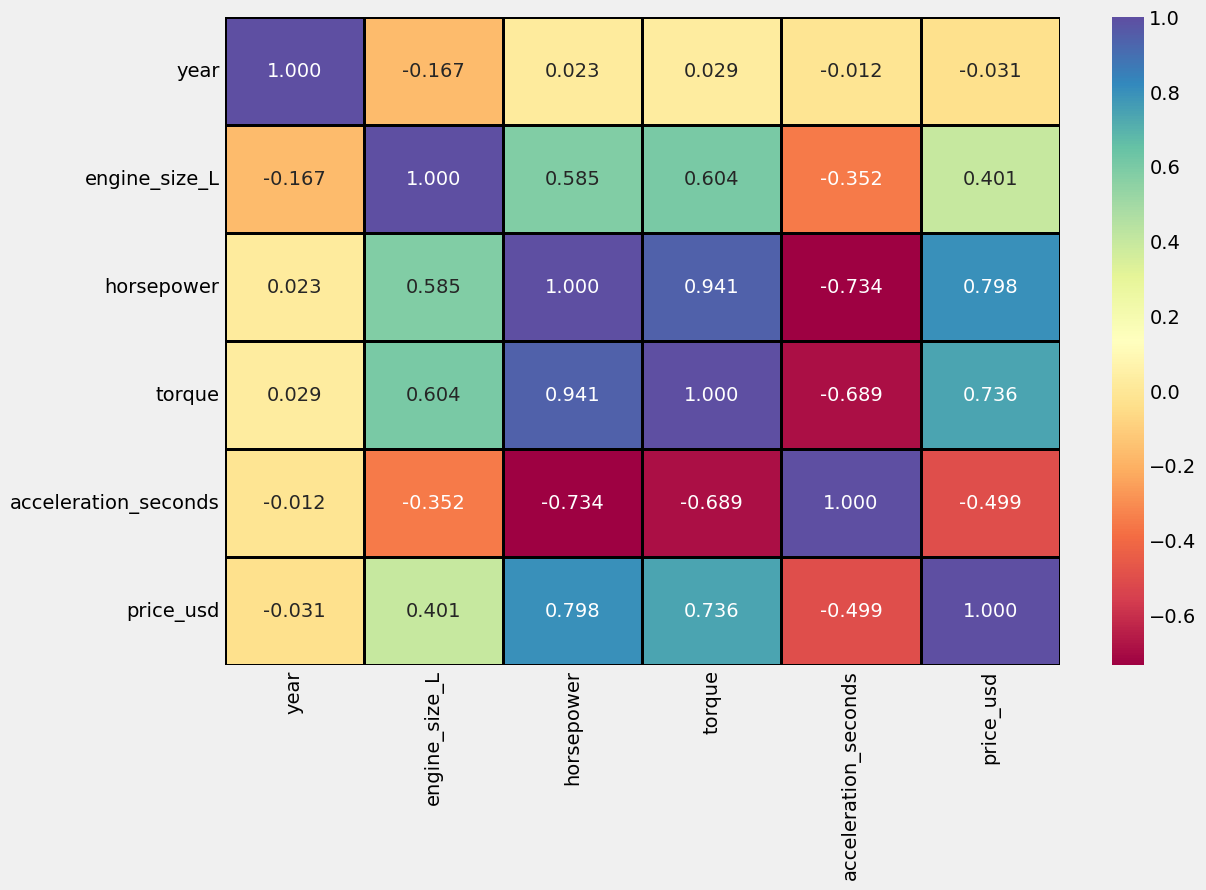

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



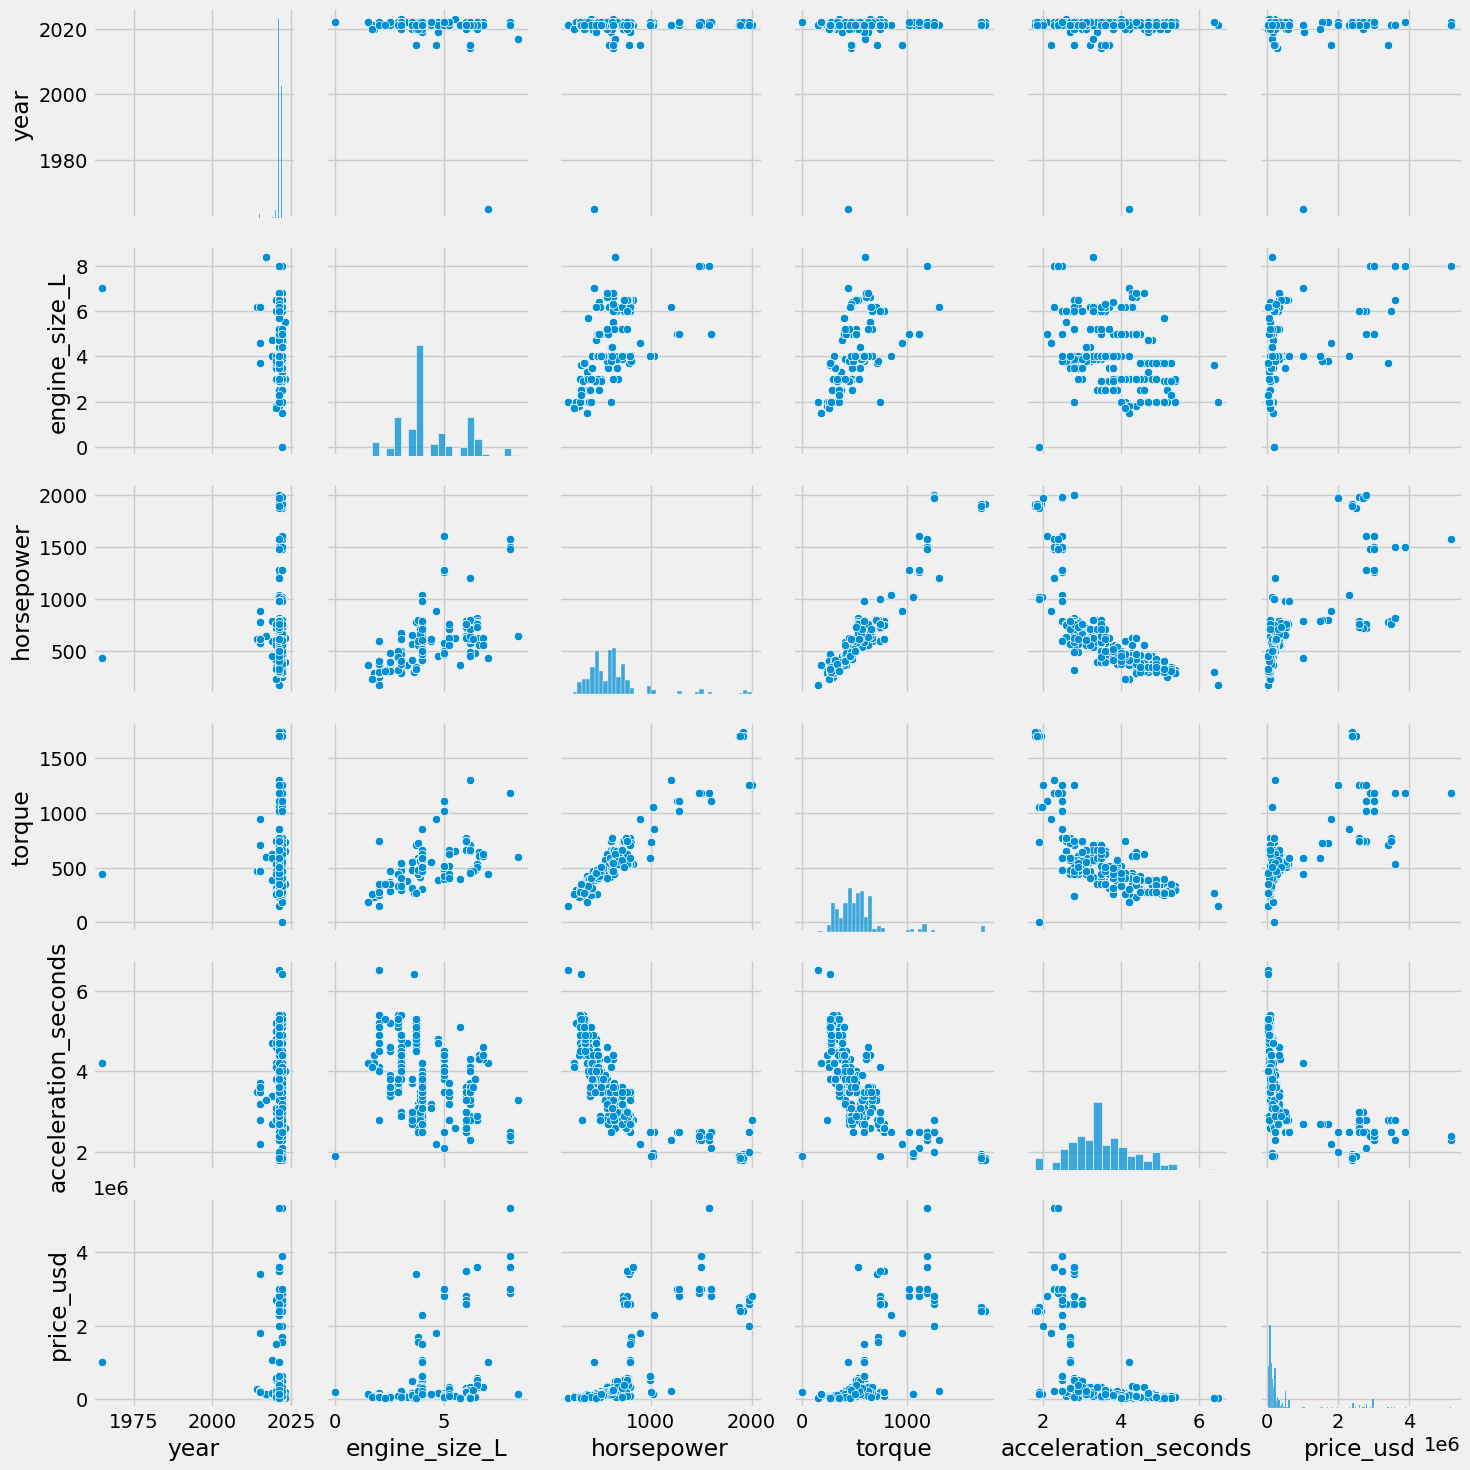

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



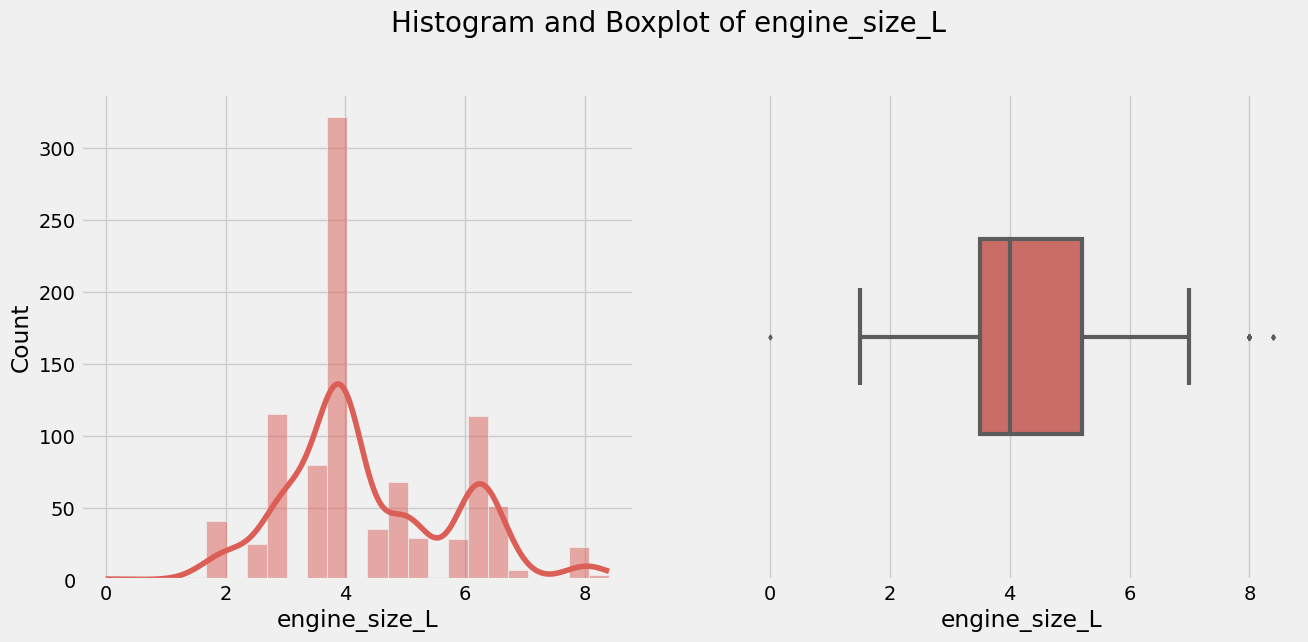

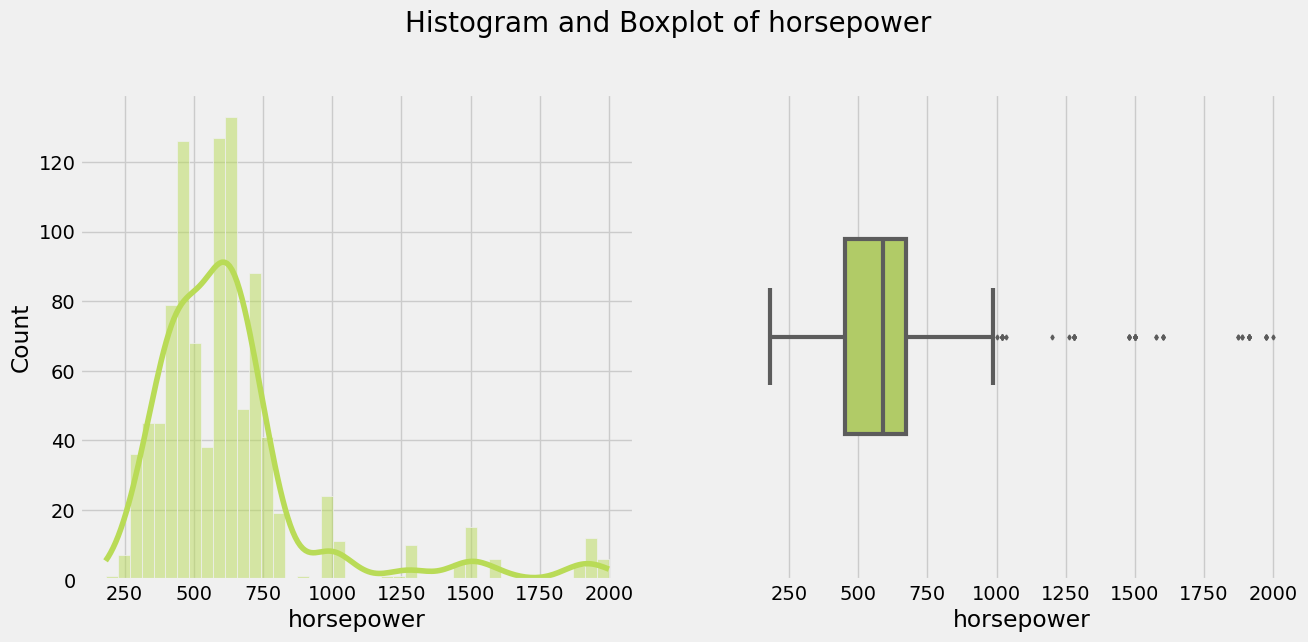

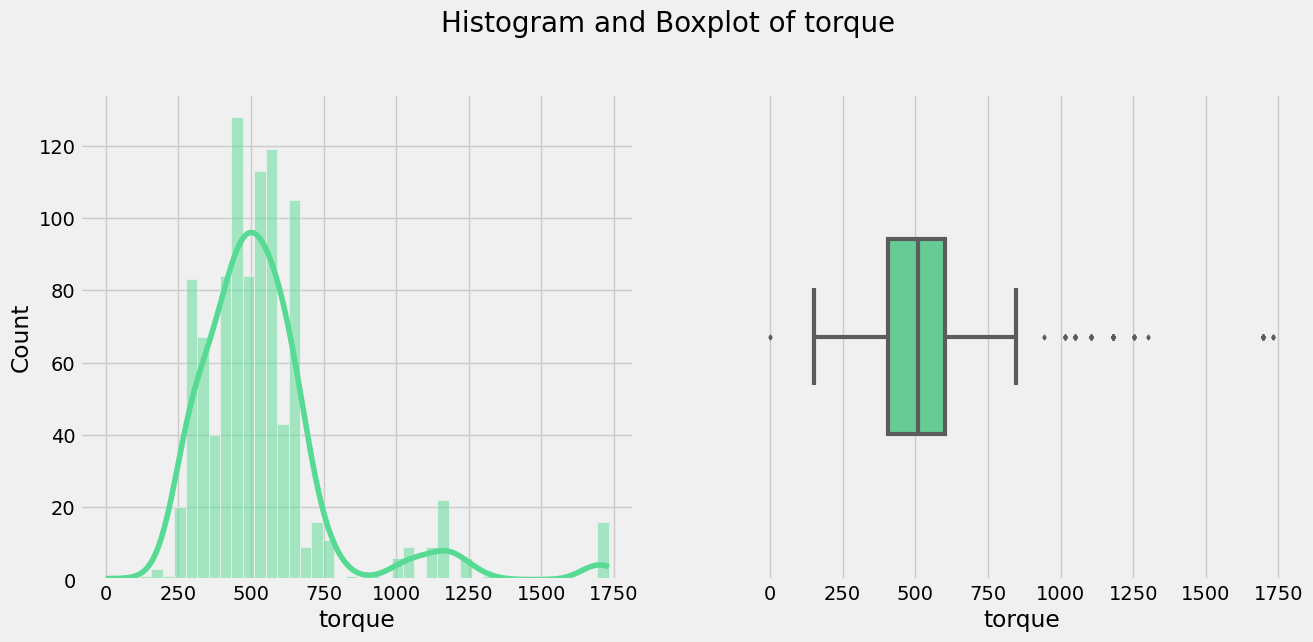

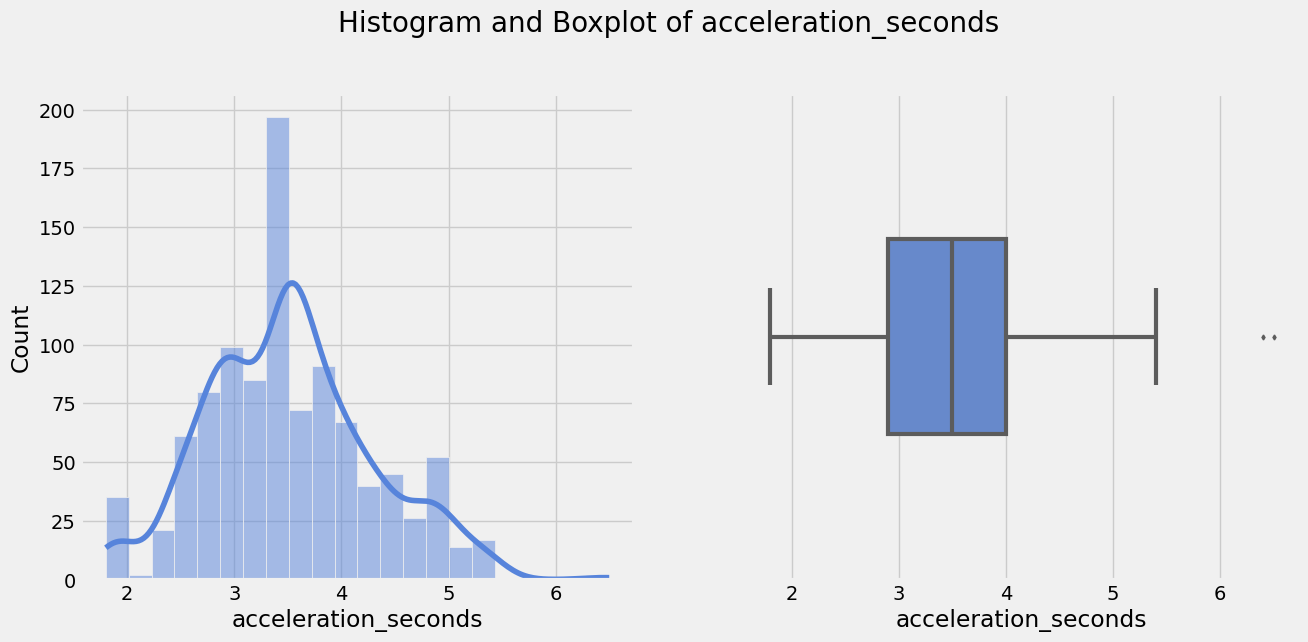

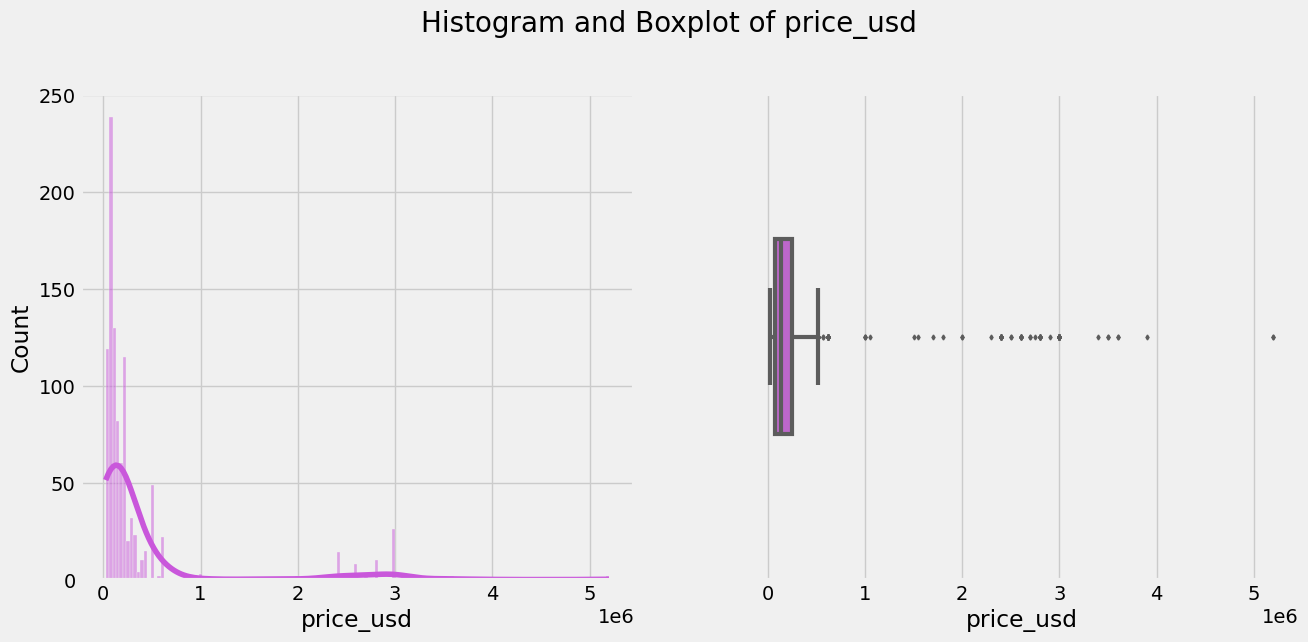

----------------------------------------------------------------------------------------------------
Countplot(s):



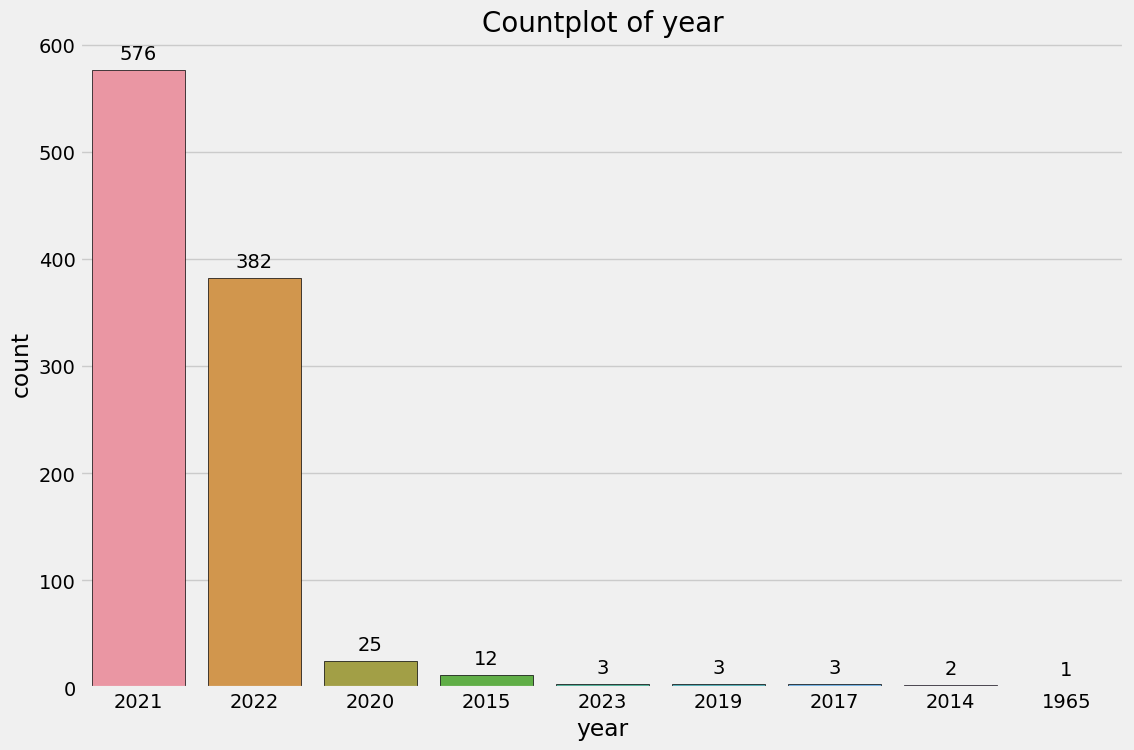

In [12]:
#Doing a fast Exploratory data analysis of the dataset
fast_eda(dataset)

In [13]:
#Create an array of columns
columns = np.array(dataset.columns)

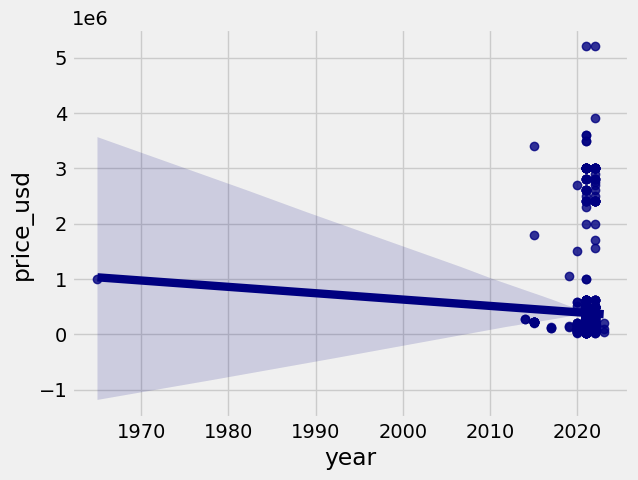

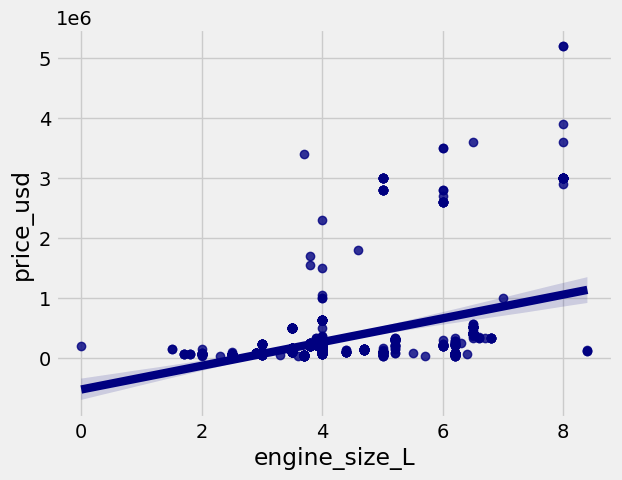

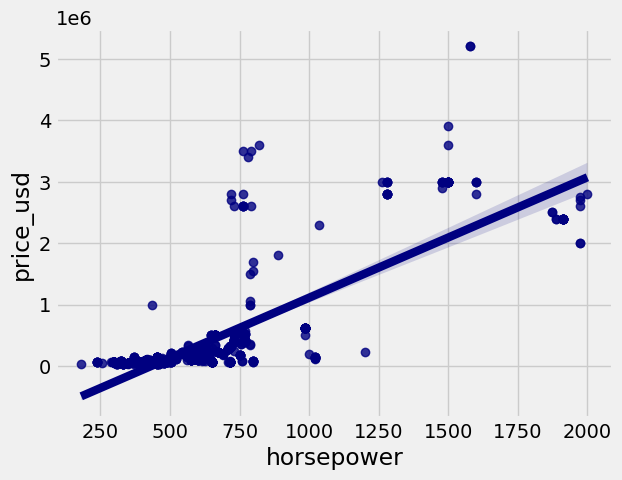

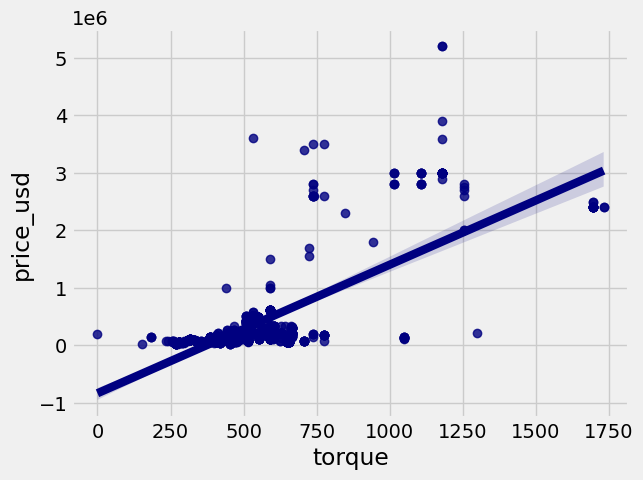

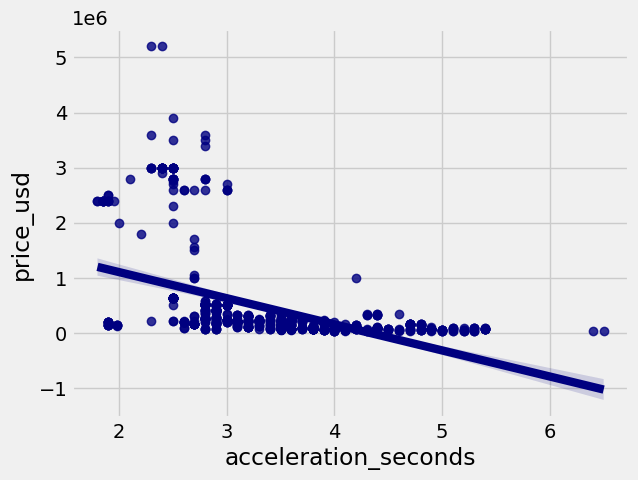

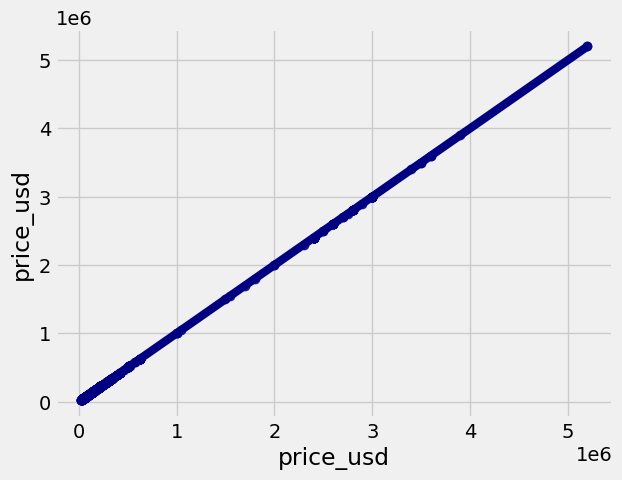

In [14]:
#Plot the regression plot to understand the relationship
#between the features and the target variables
for col in columns[2:]:
    sns.regplot(x=col, y='price_usd', color = 'navy',data =dataset)
    plt.show()

In [15]:
# I encoded the categorical variables with Target Encoding instead of 
# Label Encoding and One Hot Encoding because it gave me better results , 
# if there are better ways to encode please let me know 
import category_encoders as ce
cat_features = dataset.select_dtypes(include= ['object']).columns
encoders = ce.TargetEncoder(cols = cat_features)
target = dataset[['price_usd']]
train = dataset.drop(['price_usd'],axis = 1)
encoded_features = encoders.fit_transform(train,target)

In [16]:
# Transform skewed data into a more normal distribution using boxcox1p function
numeric_features = encoded_features.dtypes[encoded_features.dtypes != "object"].index
from scipy.stats import skew
skewed_feats = encoded_features[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness = skewness[abs(skewness['Skew'])>0.75]
skewed_features = skewness.index
for i in skewed_features:
    encoded_features[i] = boxcox1p(encoded_features[i],0.15)

In [17]:
#Imputing the data using Multiple Imputation by Chained Equations
from fancyimpute import IterativeImputer
imputer = IterativeImputer()
encoded_imputed_features =  imputer.fit_transform(encoded_features)

In [18]:
# Reset_index for dataframe manually
dataset = pd.DataFrame(data = encoded_imputed_features,columns = columns[:-1])

In [19]:
# Split the data into training and test set 0.8:0.2
X_train,X_test,Y_train,Y_test = train_test_split(dataset,target,test_size=0.2)

In [21]:
lm = LinearRegression()
lm.fit(X_train,Y_train)
rfe = RFE(lm)
rfe= rfe.fit(X_train,Y_train)

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
X_train = X_train[X_train.columns[rfe.support_]]

In [22]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [23]:
X_train_new= build_model(X_train,Y_train)

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     513.1
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          3.43e-290
Time:                        20:37:48   Log-Likelihood:                -11352.
No. Observations:                 805   AIC:                         2.272e+04
Df Residuals:                     797   BIC:                         2.276e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.009e+07 

With those results, the not significant columns are erased from the Linear Regression model to see if the R-squared with fewer variables keeps almost the same value. For choosing those variables the following criteria were applied:

In a numerical column only a variable is preserved if the P-value is less than 0.05

After the analysis , the model will be trained again:

In [24]:
X_train_new = X_train.drop(['year'], axis = 1)
X_test = X_test.drop(['year'], axis = 1)

In [25]:
stats = build_model(X_train_new,Y_train)

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     599.2
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          1.45e-291
Time:                        20:39:17   Log-Likelihood:                -11352.
No. Observations:                 805   AIC:                         2.272e+04
Df Residuals:                     798   BIC:                         2.275e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.684e+06 

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(loss='huber', max_depth=2, n_estimators=4000,
                          random_state=1, subsample=0.75)

In [28]:
model.fit(X_train_new,Y_train)

GradientBoostingRegressor(loss='huber', max_depth=2, n_estimators=4000,
                          random_state=1, subsample=0.75)

In [29]:
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train_new)
print('RMSE train data: %.3f, RMSE test data: %.3f' % (
np.sqrt(mean_squared_error(Y_train,Y_pred_train)),
np.sqrt(mean_squared_error(Y_test,Y_pred))))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(Y_train,Y_pred_train),
r2_score(Y_test,Y_pred)))

RMSE train data: 48744.889, RMSE test data: 36281.262
R2 train data: 0.996, R2 test data: 0.997


In [30]:
from sklearn.linear_model import LassoCV,ElasticNet
lasso = LassoCV(cv=10, random_state=0).fit(X_train_new, Y_train)
# Evaluate model on test data
Y_pred = lasso.predict(X_test)
Y_pred_train = lasso.predict(X_train_new)
print('MSE train data: %.3f, MSE test data: %.3f' % (
np.sqrt(mean_squared_error(Y_train,Y_pred_train)),
np.sqrt(mean_squared_error(Y_test,Y_pred))))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(Y_train,Y_pred_train),
r2_score(Y_test,Y_pred)))

MSE train data: 322572.982, MSE test data: 297898.918
R2 train data: 0.818, R2 test data: 0.795


In [32]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 100,
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train_new,Y_train)
forest_train_pred = forest.predict(X_train_new)
forest_test_pred = forest.predict(X_test)
print('MSE train data: %.3f, MSE test data: %.3f' % (
np.sqrt(mean_squared_error(Y_train,forest_train_pred)),
np.sqrt(mean_squared_error(Y_test,forest_test_pred))))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(Y_train,forest_train_pred),
r2_score(Y_test,forest_test_pred)))

MSE train data: 55389.784, MSE test data: 37385.215
R2 train data: 0.995, R2 test data: 0.997
